<a href="https://colab.research.google.com/github/Wally0924/Embedded-Systems/blob/main/homework/direction/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##圖片分類 四個方向

In [ ]:
import os
import shutil
# 設定包含圖片的資料夾路徑
image_folder = "/content/gdrive/MyDrive/direction_dataset"  # 將此路徑替換為你的圖片資料夾路徑

# 確保目標資料夾存在，如果不存在，則創建它
output_folder = "/content/gdrive/MyDrive/direction_output"  # 將此路徑替換為你希望存放分類後圖片的資料夾路徑
os.makedirs(output_folder, exist_ok=True)

# 遍歷圖片資料夾中的每張圖片
for filename in os.listdir(image_folder):
    # 檢查圖片文件是否以特定前綴開頭
    if filename.startswith("up_"):
        # 如果是 "up" 方向的圖片，將它移至 "up" 資料夾
        target_folder = os.path.join(output_folder, "up")
    elif filename.startswith("down_"):
        # 如果是 "down" 方向的圖片，將它移至 "down" 資料夾
        target_folder = os.path.join(output_folder, "down")
    elif filename.startswith("left_"):
        # 如果是 "left" 方向的圖片，將它移至 "left" 資料夾
        target_folder = os.path.join(output_folder, "left")
    elif filename.startswith("right_"):
        # 如果是 "right" 方向的圖片，將它移至 "right" 資料夾
        target_folder = os.path.join(output_folder, "right")

    # 如果目標資料夾不存在，則創建它
    os.makedirs(target_folder, exist_ok=True)

    # 執行文件移動操作
    shutil.move(os.path.join(image_folder, filename), os.path.join(target_folder, filename))

print("圖片分類完成。")


圖片分類完成。


# train with pytorch


In [2]:
import gc
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
from tqdm.auto import tqdm
import random
from pathlib import Path
import math
from pathlib import Path

In [3]:
myseed = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## direction classify model

In [4]:
class direction_classify_model(nn.Module):
  def __init__(self):
    super(direction_classify_model, self).__init__()

    # TODO change your model & output shape is the total number of your class
    # torchvision models
    # https://pytorch.org/vision/stable/models.html
    self.cnn = torchvision.models.efficientnet_b0(weights = "IMAGENET1K_V1")
    # 四個方向
    self.fc = nn.Linear(1000 , 4)
    ##########################################
  def forward(self, img):

    out = self.cnn(img)
    out = self.fc(out)
    return out

## direction dataset

In [5]:
# TODO Complete the function
class direction_dataset(Dataset):
    # 初始化函數，接收文件列表和轉換器
    def __init__(self, files, tfm):
        super(direction_dataset, self).__init__()
        self.files = files  # 存儲文件列表
        self.transform = tfm  # 存儲圖像轉換器

    # 返回資料集的大小
    def __len__(self):
        """返回資料集的大小"""
        return len(self.files)

    # 根據索引 idx 返回圖像張量和類別標籤
    def __getitem__(self, idx):
        """返回圖像張量和類別標籤"""
        # 打開圖像文件
        im = Image.open(self.files[idx][0])
        # 使用設定的圖像轉換器進行圖像轉換
        im = self.transform(im)
        # 返回圖像和對應的類別標籤
        return im, self.files[idx][1]
##########################################


## data augmentation

In [6]:
# TODO set your img size
# torchvision transforming and augmenting images
# https://pytorch.org/vision/0.15/transforms.html
WIDTH = 320
HEIGHT = 320
image_size = (HEIGHT , WIDTH)
test_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

train_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomAdjustSharpness(1.5, p=0.5),  # 隨機調整圖像的銳度
    transforms.RandomAutocontrast(p=0.5),  # 隨機應用自動對比度調整
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),  # 隨機調整圖像的顏色
    transforms.ToTensor(),
])
##########################################

##split train & valid set

In [7]:
#前面已將圖片分為四個資料夾，分別為四個方向
def gen_train_valid_files(direction_path, train_valid_ratio):
    # 創建空的訓練和驗證文件列表
    train_files = []
    valid_files = []

    # 定義每個方向類別對應的數字標籤
    class_dic = {
        "up": 0,
        "down": 1,
        "left": 2,
        "right": 3
    }


    for class_folder in Path(direction_path).glob('*'):
        # 獲取資料夾中的所有圖像文件列表
        img_list = [i for i in class_folder.glob('*.jpg')]
        for idx, img_file in enumerate(img_list):
            # 根據設定的比例將圖像文件添加到訓練或驗證列表中
            if idx < len(img_list) * train_valid_ratio:
                train_files.append([img_file, class_dic[class_folder.stem]])
            else:
                valid_files.append([img_file, class_dic[class_folder.stem]])

    # 打印訓練集和驗證集的大小
    print(f"訓練集大小：{len(train_files)}")
    print(f"驗證集大小：{len(valid_files)}")

    # 返回訓練和驗證文件列表
    return train_files, valid_files


## hyperparameter

In [8]:
import torch
import torchvision

# TODO you can adjust hyperparameter
device = "cuda" if torch.cuda.is_available() else "cpu"
model = direction_classify_model().to(device)
batch_size = 8
n_epochs = 5
patience = 10
# 定義損失函數
criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)
# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
_exp_name = "dircetion_classfication_model"
direction_path = "/content/gdrive/MyDrive/direction_output"
train_valid_ratio = 0.9
##########################################

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 56.5MB/s]


In [9]:

# TODO build your dataset
train_files , valid_files = gen_train_valid_files(direction_path , train_valid_ratio)
train_set = direction_dataset(train_files,tfm = train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = direction_dataset(valid_files, tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
##########################################

訓練集大小：113
驗證集大小：11


## training

In [10]:
stale = 0
best_acc = 0
train_acc_record = []
train_loss_record = []
valid_acc_record = []
valid_loss_record = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):

        imgs , labels = batch

        logits = model(imgs.to(device))


        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_acc_record.append(train_acc.to('cpu'))
    train_loss_record.append(train_loss)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    valid_acc_record.append(valid_acc.to('cpu'))
    valid_loss_record.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.pt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/15 [00:00<?, ?it/s]

[ Train | 001/005 ] loss = 0.73595, acc = 0.71667


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 001/005 ] loss = 0.44294, acc = 0.93750
[ Valid | 001/005 ] loss = 0.44294, acc = 0.93750 -> best
Best model found at epoch 0, saving model


  0%|          | 0/15 [00:00<?, ?it/s]

[ Train | 002/005 ] loss = 0.59570, acc = 0.84167


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 002/005 ] loss = 0.34878, acc = 0.93750
[ Valid | 002/005 ] loss = 0.34878, acc = 0.93750


  0%|          | 0/15 [00:00<?, ?it/s]

[ Train | 003/005 ] loss = 0.37259, acc = 0.92500


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 003/005 ] loss = 0.22490, acc = 1.00000
[ Valid | 003/005 ] loss = 0.22490, acc = 1.00000 -> best
Best model found at epoch 2, saving model


  0%|          | 0/15 [00:00<?, ?it/s]

[ Train | 004/005 ] loss = 0.30183, acc = 0.98333


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 004/005 ] loss = 0.24661, acc = 1.00000
[ Valid | 004/005 ] loss = 0.24661, acc = 1.00000


  0%|          | 0/15 [00:00<?, ?it/s]

[ Train | 005/005 ] loss = 0.36070, acc = 0.91667


  0%|          | 0/2 [00:00<?, ?it/s]

[ Valid | 005/005 ] loss = 0.24009, acc = 1.00000
[ Valid | 005/005 ] loss = 0.24009, acc = 1.00000


## train log

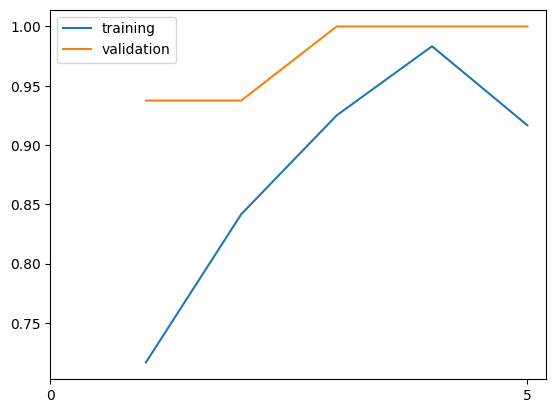

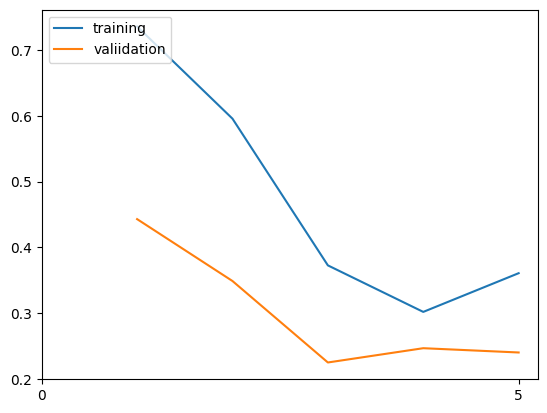

In [11]:
import matplotlib.pyplot as plt

plt.plot([*range(1,len(train_acc_record)+1)] , train_acc_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_acc_record , label = "validation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('acc.png')
plt.show()


plt.plot([*range(1,len(train_acc_record)+1)] , train_loss_record , label = "training")
plt.plot([*range(1,len(train_acc_record)+1)] , valid_loss_record , label = "valiidation")

plt.xticks(np.arange(0, n_epochs+1, 5))
plt.legend(loc="upper left")

plt.savefig('loss.png')
plt.show()

# .pt model to .onnx

In [22]:
!pip install onnx
# !wget https://npr.brightspotcdn.com/7c/15/1d76bc934e8cb103a56d43eedc7b/sunflower-wide.jpg -O sunflower.jpg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 50.7 MB/s eta 0:00:00


## check model

In [21]:
# TODO you can check your model or skip this block
model = direction_classify_model()
model.load_state_dict(torch.load(f"{_exp_name}_best.pt"))
model.eval()

im = Image.open("/content/gdrive/MyDrive/direction_output/right/right_1696489086.jpg")
im = test_tfm(im)
pred = model(im.unsqueeze(0))
label = np.argmax(pred.data.numpy(), axis=1)
softmax = torch.nn.Softmax(dim = 1)
conf = softmax(pred)
class_dic = {
    0:"up",
    1:"down",
    2:"left",
    3:"right"
}


print(class_dic[label[0]] , conf[0][label].item())
##########################################

right 0.9772762656211853


## export to onnx

In [23]:
# Input to the model
batch_size = 1
x = torch.randn(batch_size, 3, HEIGHT , WIDTH , requires_grad=True)
torch_out = model(x)
# Export the model
torch.onnx.export(model,# model being run
        x,   # model input (or a tuple for multiple inputs)
        f"{_exp_name}_best.onnx",  # where to save the model (can be a file or file-like object)
        export_params=True, # store the trained parameter weights inside the model file
        opset_version=10,   # the ONNX version to export the model to
        do_constant_folding=True, # whether to execute constant folding for optimization
        input_names = ['input'],  # the model's input names
        output_names = ['output'], # the model's output names
        dynamic_axes={'input' : {0 : 'batch_size'}, # variable length axes
            'output' : {0 : 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

